# **0. Load Preliminary Functions**

# a. Import Libraries and Functions

In [ ]:
%pip install torchdiffeq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchdiffeq

from torchvision import datasets
from torchvision import models
from torchvision import transforms
from torch.autograd import Variable
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import tqdm
import numpy as np
import pickle
import itertools
import math


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# b. MNIST Data Loader

In [ ]:
tensor_transform = transforms.Compose([
    transforms.ToTensor()
])

batch_size = 256
train_dataset = datasets.MNIST(root = "./data",
									train = True,
									download = True,
									transform = tensor_transform)
test_dataset = datasets.MNIST(root = "./data",
									train = False,
									download = True,
									transform = tensor_transform)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
							   batch_size = batch_size,
								 shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
							   batch_size = batch_size,
								 shuffle = False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 529kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.70MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.10MB/s]


# **1. Class Conditional Conditional Flow Matching**

# a. Building Blocks

In [17]:
class ResidualConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.same_channels = in_channels==out_channels
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
          x1 = self.conv1(x)
          x2 = self.conv2(x1)
          if self.same_channels:
              out = x + x2
          else:
              out = x1 + x2
          return out / 1.414


class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        layers = [ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x


class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)


class UNet(nn.Module):
    def __init__(self, in_channels, n_feat = 256, n_classes=10):
        super(UNet, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_classes = n_classes

        self.init_conv = ResidualConvBlock(in_channels, n_feat)

        self.down1 = UnetDown(n_feat, n_feat) # half_size
        self.down2 = UnetDown(n_feat, 2 * n_feat) #half_size double channel

        self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())

        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_classes, 2*n_feat)
        self.contextembed2 = EmbedFC(n_classes, 1*n_feat)

        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 7, 7),
            nn.GroupNorm(8, 2 * n_feat),
            nn.ReLU(),
        )

        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, t):
        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2)

        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)

        up1 = self.up0(hiddenvec)
        up2 = self.up1(up1 + temb1, down2)
        up3 = self.up2(up2 + temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out

# b. Optimal Transport Conditional Vector Fields

In [22]:
def pad_t_like_x(t, x):
    if isinstance(t, (float, int)):
        return t
    return t.reshape(-1, *([1] * (x.dim() - 1)))


class ConditionalFlowMatcher:
    def __init__(self, sigma = 0.0):
        self.sigma = sigma

    def compute_mu_t(self, x0, x1, t):
        return x1 * pad_t_like_x(t, x1)
        ##################
        ### Problem 1 (a): mean_t
        ##################

    def compute_sigma_t(self, t):
        return 1 - (1 - self.sigma) * t
        ##################
        ### Problem 1 (b): sigma_t
        ##################

    def get_alpha_t(self, t):
        """计算 alpha_t，使用余弦调度"""
        return torch.cos(t * math.pi / 2)

    def get_alpha_prime_t(self, t):
        """计算 alpha_t 的导数 alpha'_t"""
        return -torch.sin(t * math.pi / 2) * (math.pi / 2)

    def compute_conditional_flow(self, x0, x1, t, xt):
        # top = x1 - (1 - self.sigma) * xt
        # below = 1 - ( 1- self.sigma) * pad_t_like_x(t, x0)
        # return top / below

        alpha_t = self.get_alpha_t(1-t)
        alpha_prime_t = self.get_alpha_prime_t(1-t)
        alpha_t_padded = pad_t_like_x(alpha_t, xt)
        alpha_prime_t_padded = pad_t_like_x(alpha_prime_t, xt)
        first_part = alpha_prime_t_padded / (1 - alpha_t_padded**2 + 1e-8)

        second_part = alpha_t_padded * xt - x1
        return first_part * second_part
        ##################
        ### Problem 1 (c): ut(x1|x0)
        ##################

    def sample_xt(self, x0, x1, t, epsilon):
        # mu = self.compute_mu_t(x0, x1, t)
        # sigma = self.compute_sigma_t(t)
        # return mu + pad_t_like_x(sigma, x0) * epsilon
        # t:0 -> 1 img -> noise so t_cur = 1 -> 0 noise -> img
        t = 1-t
        alpha_t = self.get_alpha_t(t)
        sigma_t = torch.sqrt(1-alpha_t**2)
        mu = pad_t_like_x(alpha_t, x1) * x1
        return mu + pad_t_like_x(sigma_t, x0) * epsilon

        ##################
        ### Problem 1 (d): xt
        ##################

    def sample_noise_like(self, x):
        return torch.randn_like(x)

    def sample_location_and_conditional_flow(self, x0, x1, t=None, return_noise=False):
        if t is None:
            t = torch.rand(x0.shape[0]).type_as(x0)
        assert len(t) == x0.shape[0], "t has to have batch size dimension"

        eps = self.sample_noise_like(x0)
        xt = self.sample_xt(x0, x1, t, eps)
        ut = self.compute_conditional_flow(x0, x1, t, xt)
        if return_noise:
            return t, xt, ut, eps
        else:
            return t, xt, ut

# c. Training Functions

In [23]:
def train_main_loop(n_epochs, optimizer, FM, model):
  for epoch in range(n_epochs):
      print(f'epoch {epoch}')
      pbar = tqdm(train_loader)
      for i, data in enumerate(pbar):
          optimizer.zero_grad()
          x1 = data[0].to(device)
          x0 = torch.randn_like(x1)
          t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)
          vt = model(xt, t)
          loss = torch.mean((vt - ut) ** 2)
          loss.backward()
          optimizer.step()
          pbar.set_description(f"loss: {loss.item():.4f}")

      with torch.no_grad():
        traj = torchdiffeq.odeint(
          lambda t, x: model.forward(x, t),
          torch.randn(100, 1, 28, 28, device=device),
          torch.linspace(0, 1, 2, device=device),
          # torch.linspace(1, 0, 2, device=device),
          atol=1e-4,
          rtol=1e-4,
          method="dopri5",
      )

      grid = make_grid(
          traj[-1, :100].view([-1, 1, 28, 28]).clip(0, 1), value_range=(0, 1), padding=0, nrow=10
      )

      img = ToPILImage()(grid)
      plt.imshow(img)
      plt.show()

# e. Training


epoch 0


loss: 0.2136: 100%|██████████| 235/235 [01:49<00:00,  2.15it/s]


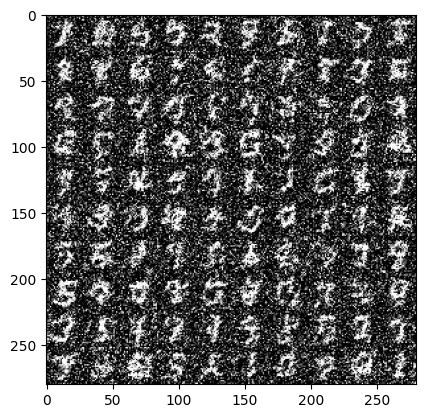

epoch 1


loss: 0.1899: 100%|██████████| 235/235 [01:49<00:00,  2.14it/s]


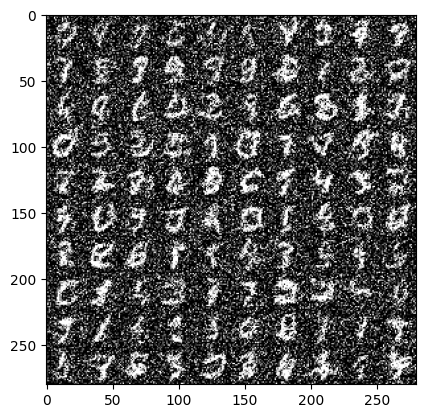

epoch 2


loss: 0.2329: 100%|██████████| 235/235 [01:49<00:00,  2.14it/s]


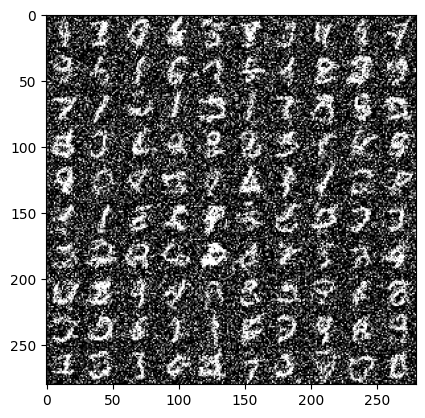

epoch 3


loss: 0.2130: 100%|██████████| 235/235 [01:50<00:00,  2.13it/s]


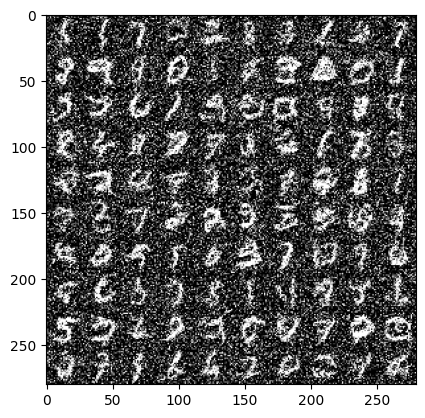

epoch 4


loss: 0.1576: 100%|██████████| 235/235 [01:50<00:00,  2.13it/s]


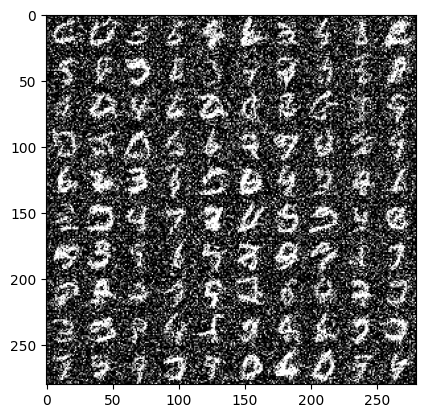

epoch 5


loss: 0.1741: 100%|██████████| 235/235 [01:50<00:00,  2.13it/s]


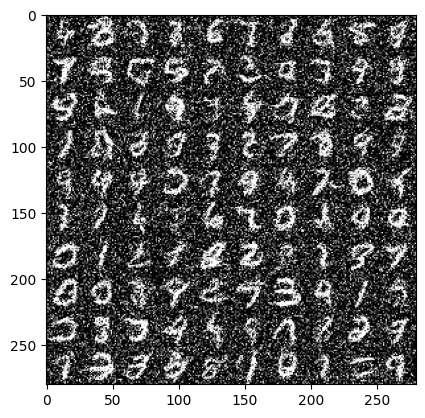

epoch 6


loss: 0.1991: 100%|██████████| 235/235 [01:51<00:00,  2.10it/s]


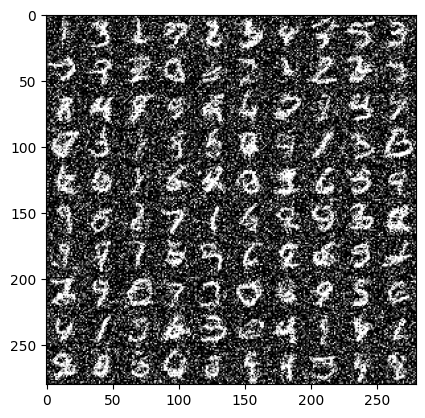

epoch 7


loss: 0.1727: 100%|██████████| 235/235 [01:50<00:00,  2.12it/s]


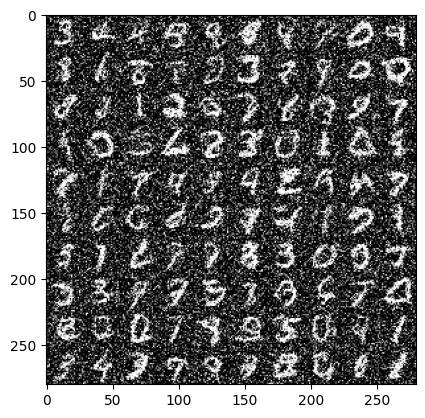

epoch 8


loss: 0.1716: 100%|██████████| 235/235 [01:50<00:00,  2.13it/s]


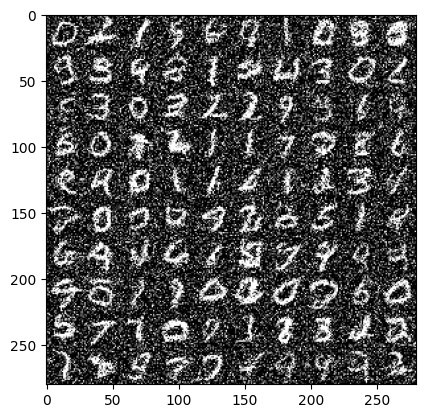

epoch 9


loss: 0.1553: 100%|██████████| 235/235 [01:50<00:00,  2.13it/s]


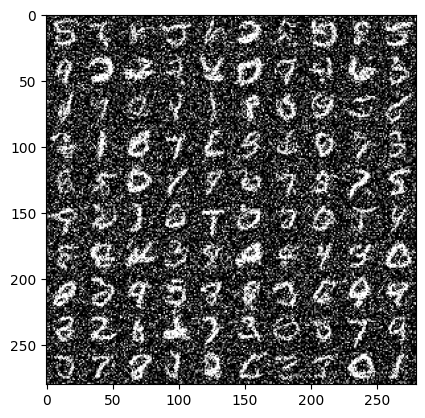

In [24]:
##################
### Problem 1 (e): training
sigma = 0.0
n_feat = 128
n_epochs = 10
model = UNet(in_channels=1, n_feat=n_feat, n_classes=10).to(device)



optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
FM = ConditionalFlowMatcher(sigma=sigma)

train_main_loop(n_epochs, optimizer, FM, model)
##################


# **2. Ablation Study**

In [ ]:
##################
### Problem 2: Ablation Study
##################

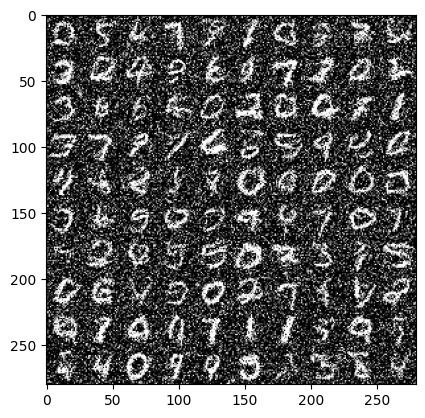

In [25]:
with torch.no_grad():
  traj = torchdiffeq.odeint(
      lambda t, x: model.forward(x, t),
      torch.randn(100, 1, 28, 28, device=device),
      torch.linspace(0, 1, 100, device=device), #100 step
      atol=1e-4,
      rtol=1e-4,
      method="dopri5",
  )
  grid = make_grid(
          traj[-1, :100].view([-1, 1, 28, 28]).clip(0, 1), value_range=(0, 1), padding=0, nrow=10
      )

  img = ToPILImage()(grid)
  plt.imshow(img)
  plt.show()

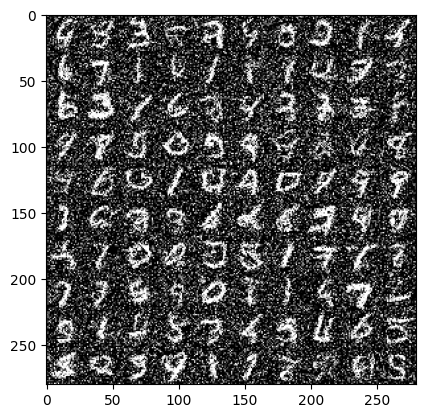

In [26]:
with torch.no_grad():
  traj = torchdiffeq.odeint(
      lambda t, x: model.forward(x, t),
      torch.randn(100, 1, 28, 28, device=device),
      torch.linspace(0, 1, 2, device=device),
      atol=1e-4,
      rtol=1e-4,
      method="dopri8",
  )
  grid = make_grid(
          traj[-1, :100].view([-1, 1, 28, 28]).clip(0, 1), value_range=(0, 1), padding=0, nrow=10
      )

  img = ToPILImage()(grid)
  plt.imshow(img)
  plt.show()

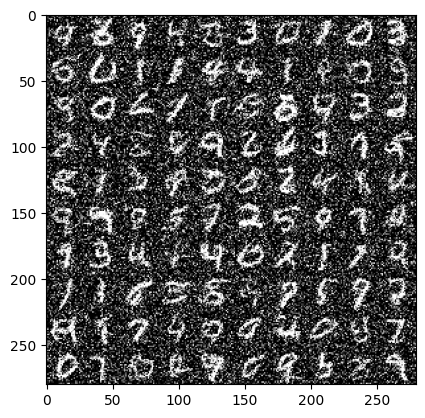

In [27]:
with torch.no_grad():
    traj = torchdiffeq.odeint(
        lambda t, x: model.forward(x, t),
        torch.randn(100, 1, 28, 28, device=device),
        torch.linspace(0, 1, 2, device=device),
        atol=1e-4,
        rtol=1e-4,
        method="bosh3",
    )
    grid = make_grid(
        traj[-1, :100].view([-1, 1, 28, 28]).clip(0, 1), value_range=(0, 1), padding=0, nrow=10
    )

    img = ToPILImage()(grid)
    plt.imshow(img)
    plt.show()

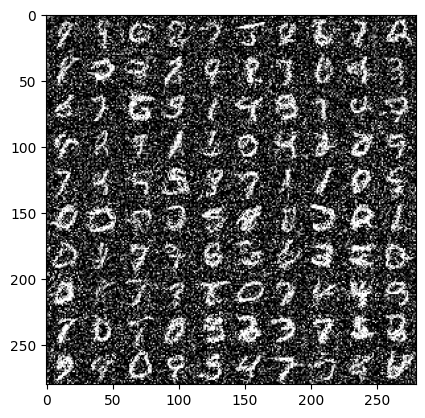

In [28]:
with torch.no_grad():
    traj = torchdiffeq.odeint(
        lambda t, x: model.forward(x, t),
        torch.randn(100, 1, 28, 28, device=device),
        torch.linspace(0, 1, 2, device=device),
        atol=1e-4,
        rtol=1e-4,
        method="fehlberg2",
    )
    grid = make_grid(
        traj[-1, :100].view([-1, 1, 28, 28]).clip(0, 1), value_range=(0, 1), padding=0, nrow=10
    )

    img = ToPILImage()(grid)
    plt.imshow(img)
    plt.show()

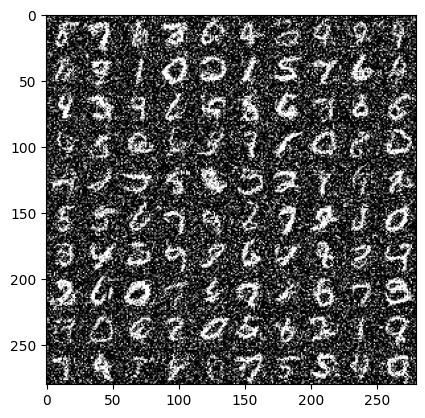

In [29]:
with torch.no_grad():

    traj = torchdiffeq.odeint(
        lambda t, x: model.forward(x, t),
        torch.randn(100, 1, 28, 28, device=device),
        torch.linspace(0, 1, 2, device=device),
        atol=1e-4,
        rtol=1e-4,
        method="adaptive_heun",
    )
    grid = make_grid(
        traj[-1, :100].view([-1, 1, 28, 28]).clip(0, 1), value_range=(0, 1), padding=0, nrow=10
    )

    img = ToPILImage()(grid)
    plt.imshow(img)
    plt.show()

# **3. Gaussian to Gaussian (2D) using a conditional flow**

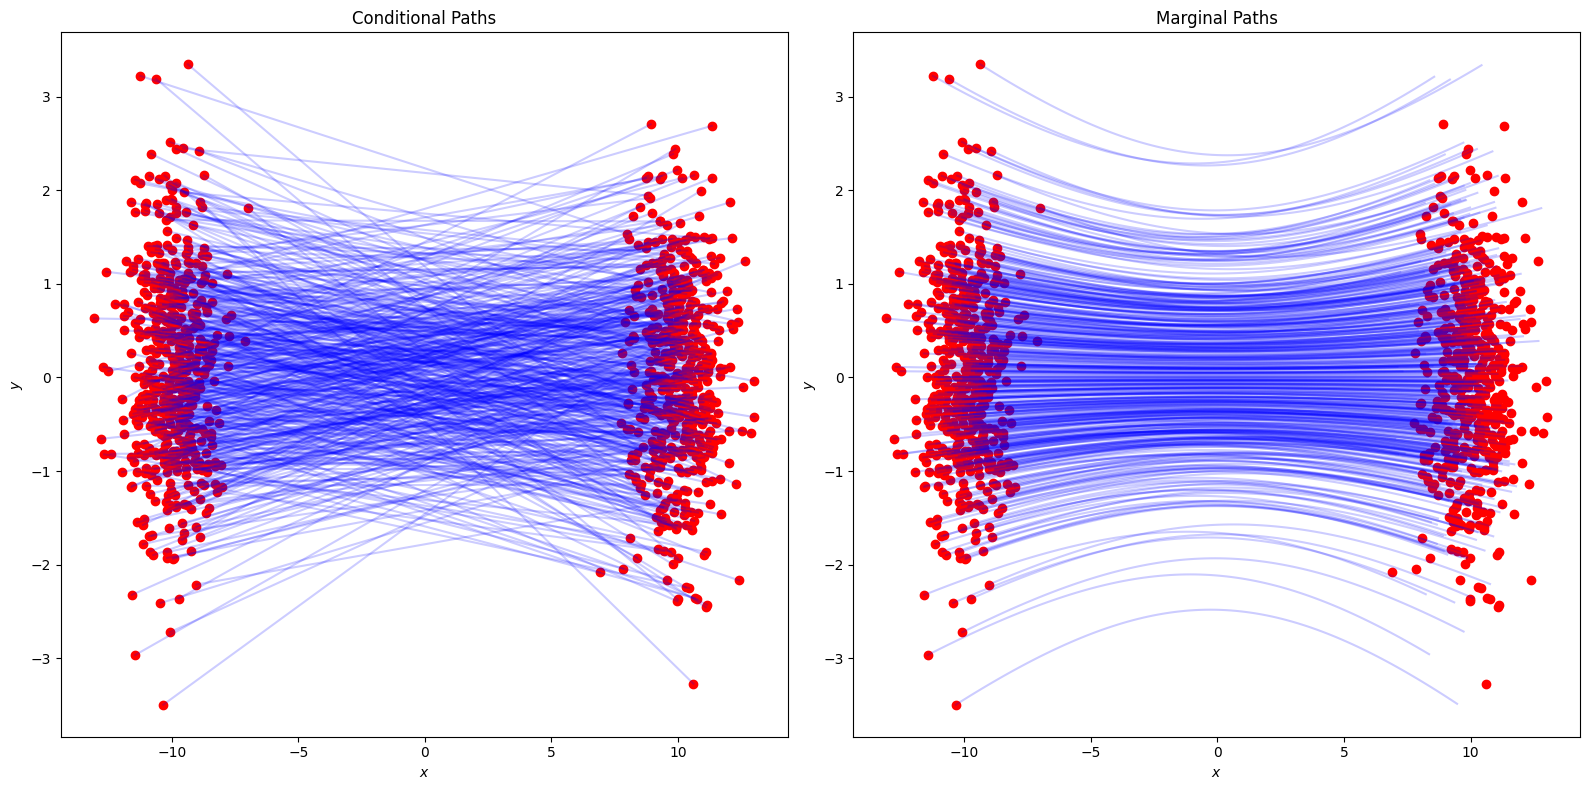

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from tqdm import tqdm

mu = 10
n_samples = 500
n_steps = 100
t_values = np.linspace(0, 1, n_steps)
t_values = t_values

mean_start = np.array([-mu, 0])
mean_end = np.array([mu, 0])
covariance = np.eye(2)

x0_samples = np.random.multivariate_normal(mean_start, covariance, n_samples)
x1_samples = np.random.multivariate_normal(mean_end, covariance, n_samples)

def conditional_paths(x0_samples, x1_samples, mean_end, t_values):
    conditional_paths = []
    for x0, x1 in zip(x0_samples, x1_samples):
        path = [(1 - t) * x0 + t * x1 for t in t_values]
        conditional_paths.append(np.array(path))
    return np.array(conditional_paths)

def marginal_flow(x, t):
    # u(x_t) = (1 / (1-t)) * [ ( (tσ_1² / σ_t²) - 1 )x_t + μ_1 - (tσ_1² / σ_t²)μ_t ]
    if t >= 1.0:
        return np.zeros_like(x)
    part1 = (1 / (1 - t))
    sigma_t_sqare = (1-t)**2*1 + t*t*1
    mu_t = (1-t)*mean_start + t*mean_end
    part2 = (t*1 / sigma_t_sqare - 1)*x
    part3 = mean_end - (t*1/sigma_t_sqare)*mu_t
    result = part1 * (part2 + part3)
    return result
    ##################
    ### Problem 3(b): u(x_t)
    ##################

def generate_marginal_paths(x0_samples, t_values):
    marginal_paths = []
    for x0 in x0_samples:
        path = [x0]
        x_current = x0
        for t in t_values[1:]:
            u_t = marginal_flow(x_current, t)
            x_current = x_current + u_t * (t_values[1] - t_values[0])
            path.append(x_current)
        marginal_paths.append(np.array(path))
    return np.array(marginal_paths)


conditional_data = conditional_paths(x0_samples, x1_samples, mean_end, t_values)
marginal_data = generate_marginal_paths(x0_samples, t_values)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

for path in conditional_data:
    axes[0].plot(path[:, 0], path[:, 1], color='blue', alpha=0.2)
axes[0].set_title("Conditional Paths")
axes[0].scatter(x0_samples[:, 0], x0_samples[:, 1], color='red')
axes[0].scatter(x1_samples[:, 0], x1_samples[:, 1], color='red')
axes[0].set_xlabel("$x$")
axes[0].set_ylabel("$y$")

for path in marginal_data:
    axes[1].plot(path[:, 0], path[:, 1], color='blue', alpha=0.2)
axes[1].set_title("Marginal Paths")
axes[1].scatter(x0_samples[:, 0], x0_samples[:, 1], color='red')
axes[1].scatter(x1_samples[:, 0], x1_samples[:, 1], color='red')
axes[1].set_xlabel("$x$")
axes[1].set_ylabel("$y$")

plt.tight_layout()
plt.show()
